# What is the most optimal skill to learn for Data Analysts?

#### Methodology
1. Calculate the percentage of job postings requiring each skill
2. Visualize median salary vs percent skill demand
3. Determine if certain technologies are more prevalent

## Import Libraries and Data

In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

# Loading Data
df = pd.read_csv('../Project/data/job_postings_flat.csv')

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

# Filter for 2025 data
df = df[df['job_posted_date'].dt.year == 2025]

## Clean Data

Filter for US Data Analyst roles with salary info, then explode skills to analyze each one individually.

In [2]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
1269573,93800.0,python
1269573,93800.0,sql
1269573,93800.0,sas
1269573,93800.0,sas
1269573,93800.0,go


## Calculate Percent of Job Postings that Have Skills

Calculate the count, median salary, and demand percentage for each skill.

In [3]:
# using df_DA find the count of skills and also the median salary for each skill
df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_US)  # Find count of Data Analyst jobs in US with salary info

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

df_DA_skills = df_DA_skills[df_DA_skills['skill_count'] > 0]

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,4528,100000.0,38.737274
excel,3516,90000.0,30.079562
python,3089,101010.0,26.426555
tableau,2641,97500.0,22.593892
power bi,2266,95000.0,19.385747
...,...,...,...
rust,1,112500.0,0.008555
redhat,1,101075.0,0.008555
qt,1,98700.0,0.008555


## Median Salary vs Percent Skill Demand

Only keep skills that appear in more than 5% of postings to focus on relevant ones.

In [4]:
skill_limit = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

### Plot Optimal Skills

Scatter plot: demand percentage vs median salary, with skill labels.

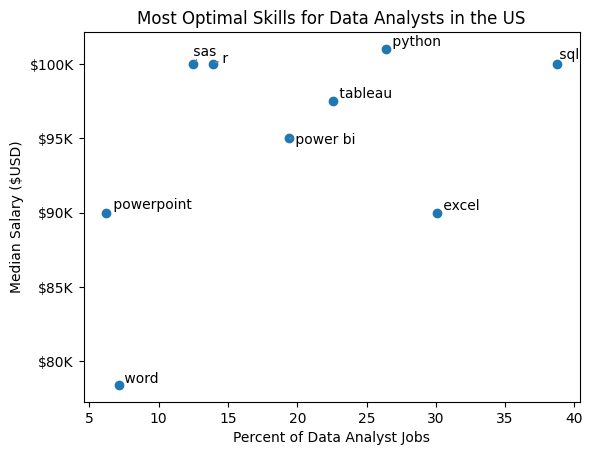

In [5]:
from adjustText import adjust_text

plt.scatter(df_DA_skills_high_demand['skill_percent'], df_DA_skills_high_demand['median_salary'])
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Salary ($USD)')
plt.title('Most Optimal Skills for Data Analysts in the US')

# Get current axes, set limits, and format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))

# Add labels to points and collect them in a list
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], " " + txt))

# Adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

## Coloring by Technology

Build a mapping of skills to technology categories (programming, databases, analyst tools, etc.) from the dataset's `job_type_skills` column.

In [6]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

{'analyst_tools': ['powerbi',
  'sharepoint',
  'esquisse',
  'microstrategy',
  'datarobot',
  'powerpoint',
  'nuix',
  'power bi',
  'word',
  'spreadsheet',
  'excel',
  'dax',
  'ssrs',
  'ms access',
  'spss',
  'looker',
  'qlik',
  'msaccess',
  'sheets',
  'sap',
  'outlook',
  'ssis',
  'visio',
  'alteryx',
  'splunk',
  'cognos',
  'tableau',
  'sas'],
 'programming': ['go',
  'c#',
  'matlab',
  'f#',
  'typescript',
  'javascript',
  'perl',
  'groovy',
  'haskell',
  'golang',
  'ocaml',
  'swift',
  'apl',
  'fortran',
  'mongodb',
  'nosql',
  'sql',
  'assembly',
  'solidity',
  'objective-c',
  'delphi',
  'erlang',
  'powershell',
  'vb.net',
  'html',
  't-sql',
  'lisp',
  'elixir',
  'r',
  'pascal',
  'java',
  'kotlin',
  'php',
  'no-sql',
  'rust',
  'css',
  'c++',
  'dart',
  'c',
  'python',
  'crystal',
  'vba',
  'scala',
  'sass',
  'julia',
  'bash',
  'shell',
  'visual basic',
  'sas',
  'mongo',
  'clojure',
  'lua',
  'ruby',
  'cobol'],
 'other': 

Convert the technology dictionary into a DataFrame and explode so each skill-technology pair gets its own row.

In [7]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,powerbi
0,analyst_tools,sharepoint
0,analyst_tools,esquisse
0,analyst_tools,microstrategy
0,analyst_tools,datarobot
...,...,...
9,async,trello
9,async,airtable
9,async,planner
9,async,wrike


Merge the skill stats with the technology categories so we can color-code the scatter plot.

In [8]:
# merge df_DA_skills and df_technology
df_DA_skills_tech = df_DA_skills.merge(df_technology, left_on='job_skills', right_on='skills')

df_DA_skills_tech

,skill_count,median_salary,skill_percent,technology,skills
0,4528,100000.0,38.737274,programming,sql
1,3516,90000.0,30.079562,analyst_tools,excel
2,3089,101010.0,26.426555,programming,python
3,2641,97500.0,22.593892,analyst_tools,tableau
4,2266,95000.0,19.385747,analyst_tools,power bi
...,...,...,...,...,...
172,1,112500.0,0.008555,programming,rust
173,1,101075.0,0.008555,os,redhat
174,1,98700.0,0.008555,libraries,qt
175,1,140000.0,0.008555,other,svn


Filter again for high-demand skills only.

In [9]:
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_limit]

### Plot with Technology Colors

Same scatter plot, now color-coded by technology category.

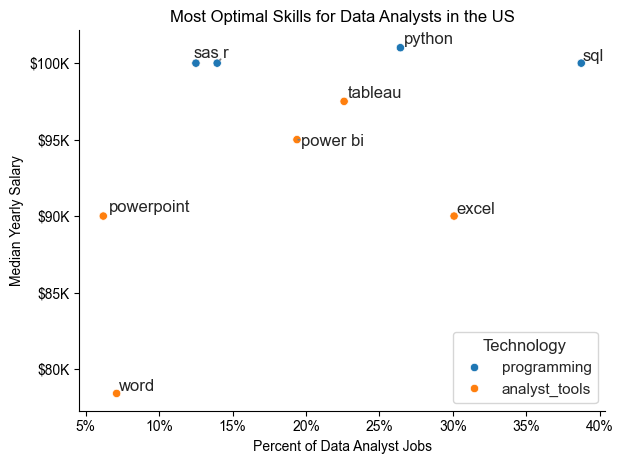

In [10]:
sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.show()